## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/dacon/2023 전력 사용량 예측')

In [3]:
import random
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings(action='ignore')

## Fixed Random-Seed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Load Data

In [5]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
building_df = pd.read_csv('./building_info.csv')

- 일조 일사 전력소비량 유무
- 일시 month day time 변환 추가
- 일조 일사 삭제
- NaN 처리

In [6]:
train_df.head(-10)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203985,100_20220824 09,100,20220824 09,23.4,NaN,1.1,87.0,0.0,NaN,1014.00
203986,100_20220824 10,100,20220824 10,23.8,NaN,1.4,85.0,0.0,NaN,1089.12
203987,100_20220824 11,100,20220824 11,23.7,0.0,0.9,87.0,0.0,NaN,1056.48
203988,100_20220824 12,100,20220824 12,24.0,0.1,1.8,78.0,0.0,NaN,1091.28


In [8]:
test_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


In [9]:
train_df.describe()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
count,204000.000000,204000.000000,43931.000000,203981.000000,203991.000000,128818.000000,116087.000000,204000.000000
mean,50.500000,25.543524,2.040830,2.134031,78.716295,0.333637,1.063823,2451.036462
std,28.866141,3.779523,5.165218,1.358109,15.080108,0.401486,1.001030,2440.648858
min,1.000000,10.100000,0.000000,0.000000,13.000000,0.000000,0.000000,0.000000
25%,25.750000,23.400000,0.000000,1.200000,69.000000,0.000000,0.200000,1085.760000
50%,50.500000,25.700000,0.100000,2.000000,81.000000,0.100000,0.710000,1766.400000
75%,75.250000,28.100000,1.300000,2.800000,91.000000,0.700000,1.780000,2970.000000
max,100.000000,37.100000,92.200000,13.300000,100.000000,1.000000,3.920000,25488.400000


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [11]:
building_df.head()

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


## Train Data Pre-Processing

In [7]:
#결측값을 0으로 채웁니다
train_df = train_df.fillna(0)

In [8]:
#시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나눕니다
train_df['month'] = train_df['일시'].apply(lambda x : int(x[4:6]))
train_df['day'] = train_df['일시'].apply(lambda x : int(x[6:8]))
train_df['time'] = train_df['일시'].apply(lambda x : int(x[9:11]))

In [9]:
train_x = train_df.drop(columns=['num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'])
train_y = train_df['전력소비량(kWh)']

In [10]:
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),month,day,time
0,1_20220601 00,1,20220601 00,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,6,1,0
1,1_20220601 01,1,20220601 01,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,6,1,1
2,1_20220601 02,1,20220601 02,17.7,0.0,1.5,45.0,0.0,0.0,974.88,6,1,2
3,1_20220601 03,1,20220601 03,16.7,0.0,1.4,48.0,0.0,0.0,953.76,6,1,3
4,1_20220601 04,1,20220601 04,18.4,0.0,2.8,43.0,0.0,0.0,986.40,6,1,4


In [16]:
train_x.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),month,day,time
0,1,18.6,0.0,0.9,42.0,6,1,0
1,1,18.0,0.0,1.1,45.0,6,1,1
2,1,17.7,0.0,1.5,45.0,6,1,2
3,1,16.7,0.0,1.4,48.0,6,1,3
4,1,18.4,0.0,2.8,43.0,6,1,4


# Data EDA

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

- 전력 소비량 정규화 필요

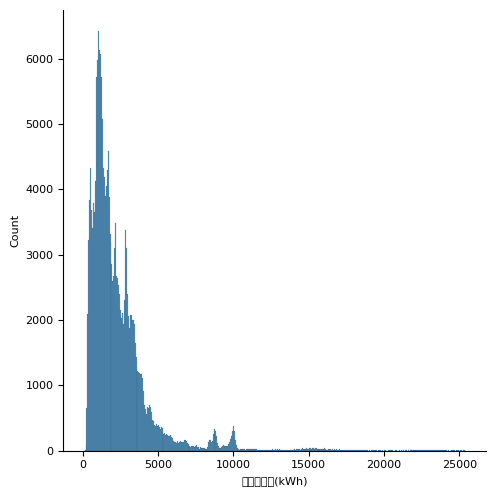

In [18]:
mpl.rc('font', size=8)
sns.displot(train_df['전력소비량(kWh)'])

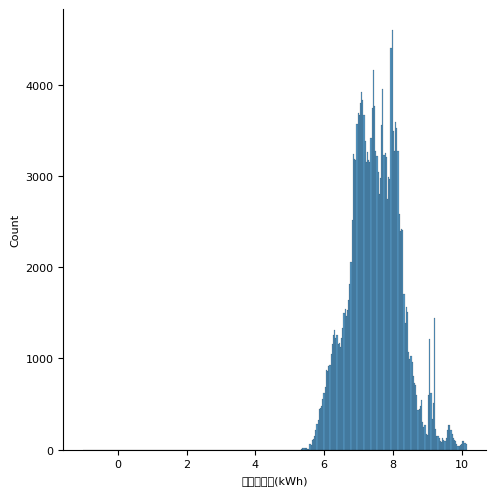

In [19]:
sns.displot(np.log(train_df['전력소비량(kWh)']))

<Axes: xlabel='time', ylabel='전력소비량(kWh)'>

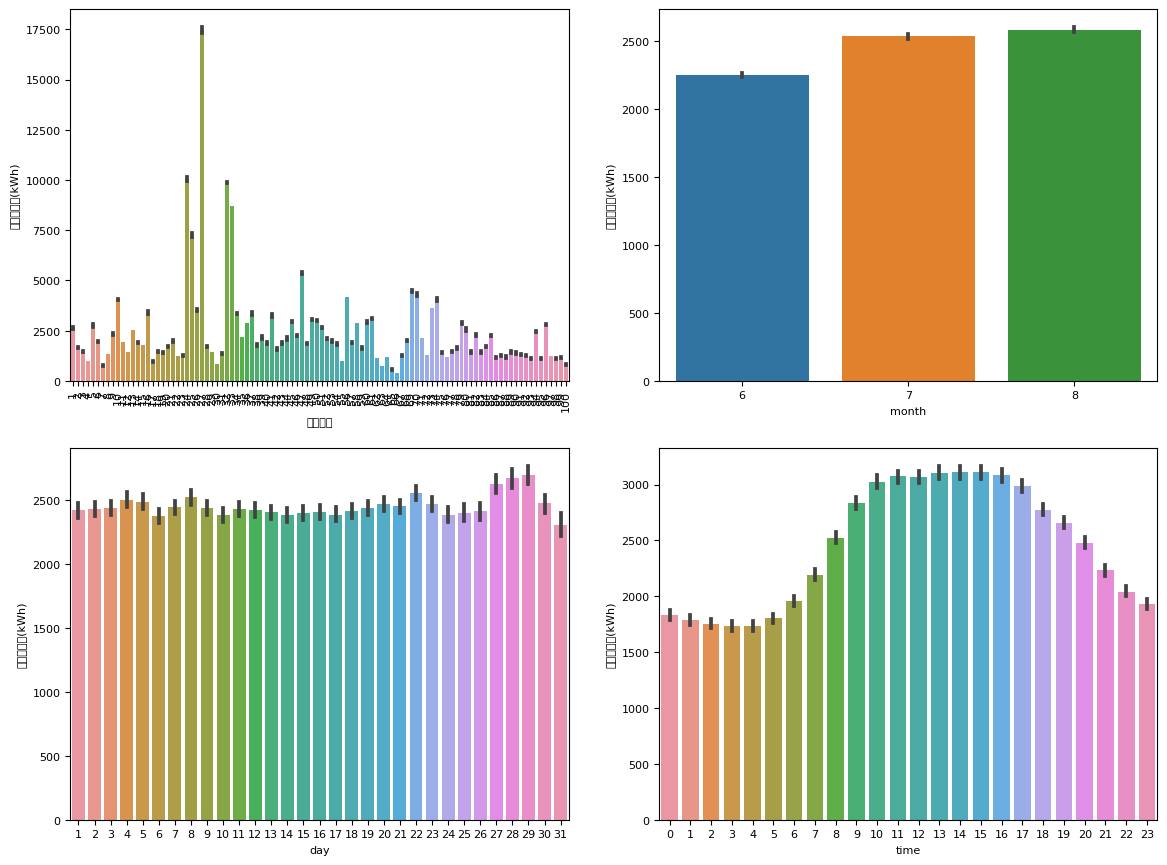

In [20]:
figure, axes = plt.subplots(nrows=2, ncols=2)
plt.tight_layout()
figure.set_size_inches(12, 9)

sns.barplot(x='건물번호', y='전력소비량(kWh)', data=train_df, ax=axes[0,0])
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=90)

sns.barplot(x='month', y='전력소비량(kWh)', data=train_df, ax=axes[0,1])
sns.barplot(x='day', y='전력소비량(kWh)', data=train_df, ax=axes[1,0])
sns.barplot(x='time', y='전력소비량(kWh)', data=train_df, ax=axes[1,1])


<Axes: xlabel='습도(%)', ylabel='전력소비량(kWh)'>

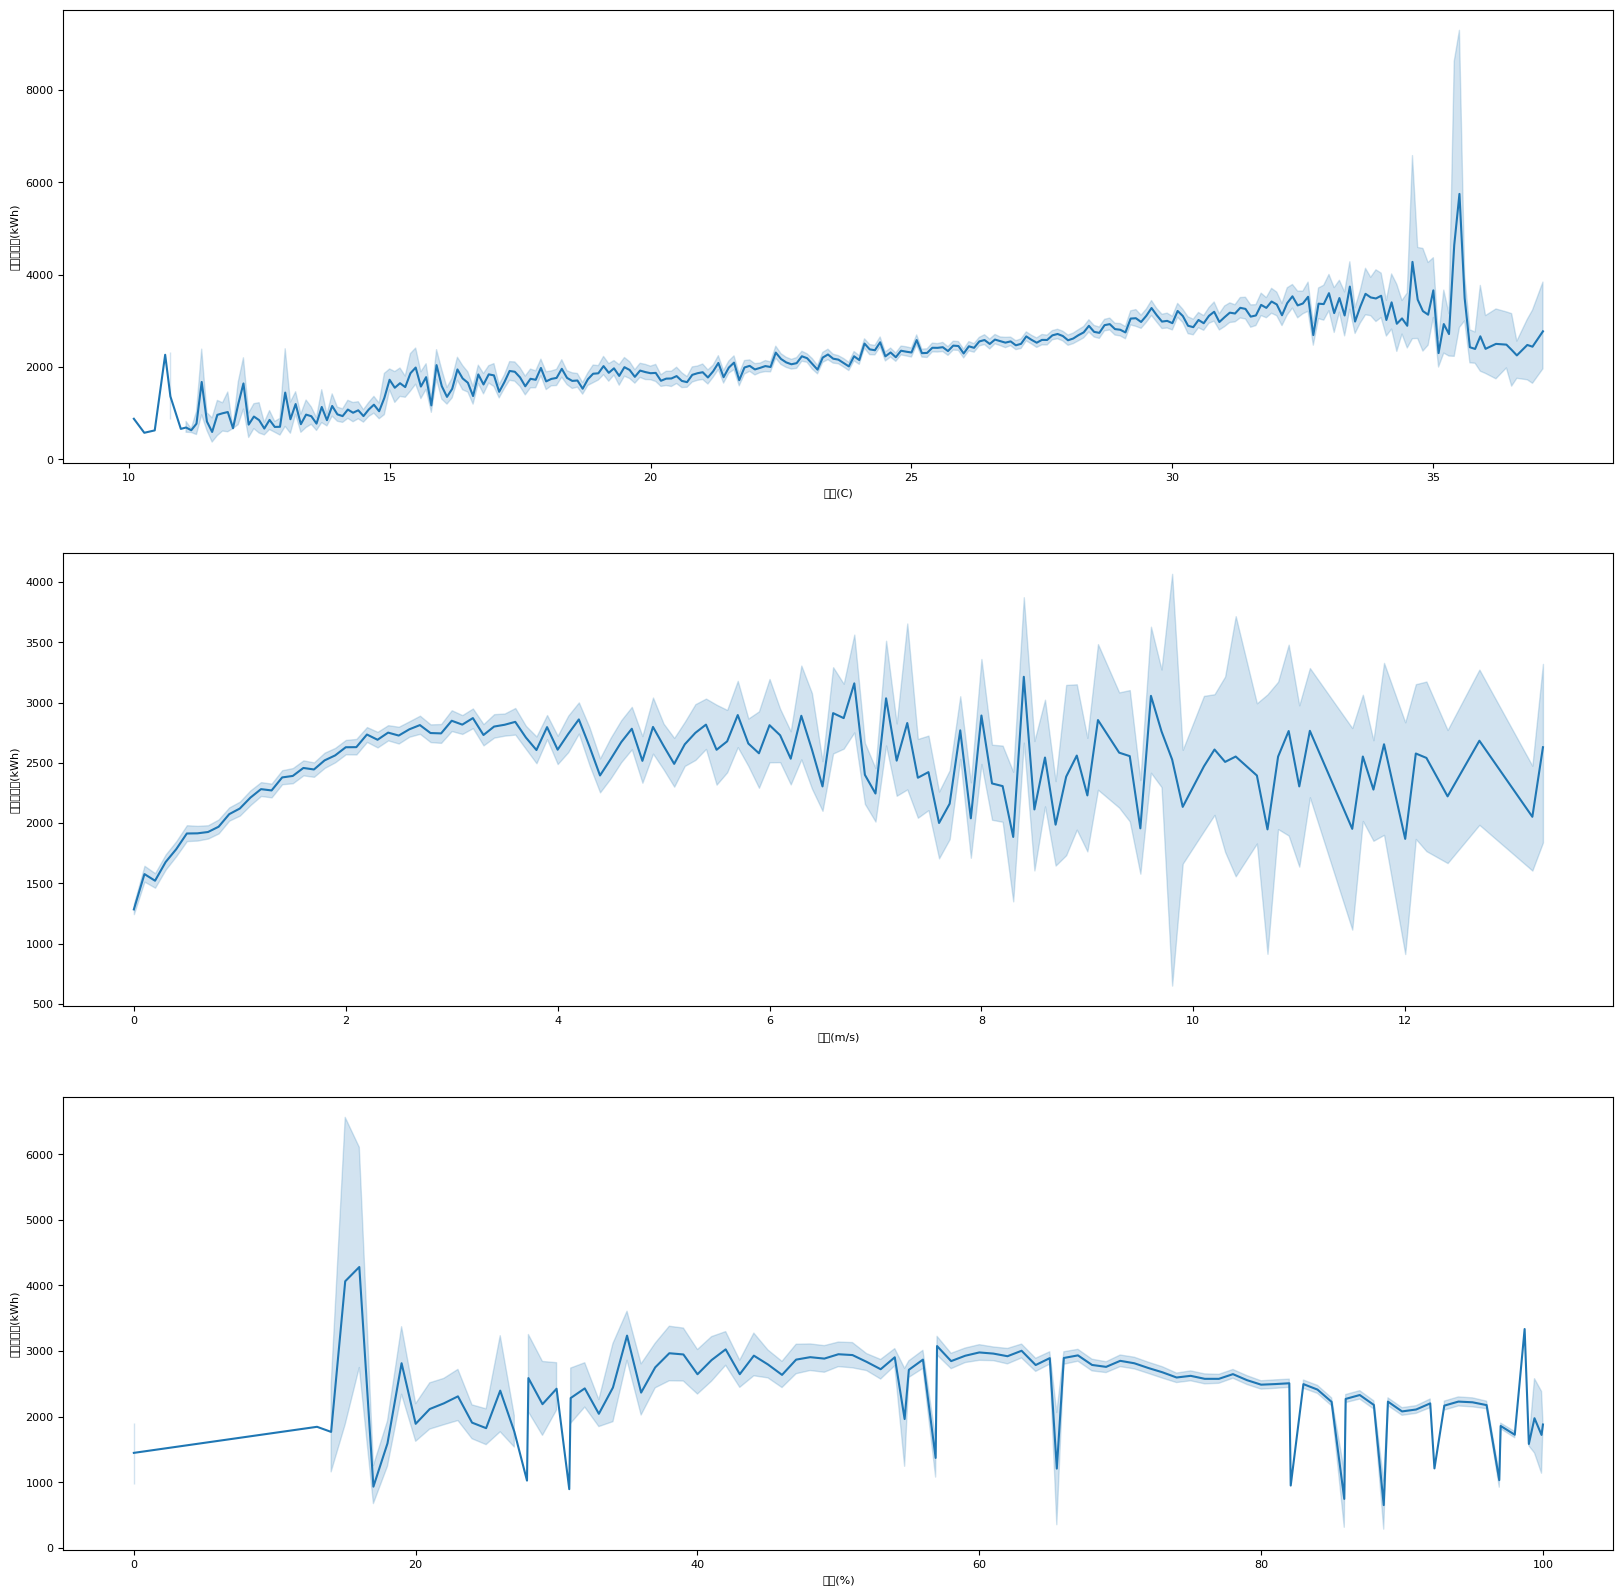

In [21]:
figure, axes = plt.subplots(nrows=3)
figure.set_size_inches(20,20)

sns.lineplot(x='기온(C)', y='전력소비량(kWh)', data=train_df, ax=axes[0])
sns.lineplot(x='풍속(m/s)', y='전력소비량(kWh)', data=train_df, ax=axes[1])
sns.lineplot(x='습도(%)', y='전력소비량(kWh)', data=train_df, ax=axes[2])


[Text(0.5, 1.0, 'Heatmap of climate data')]

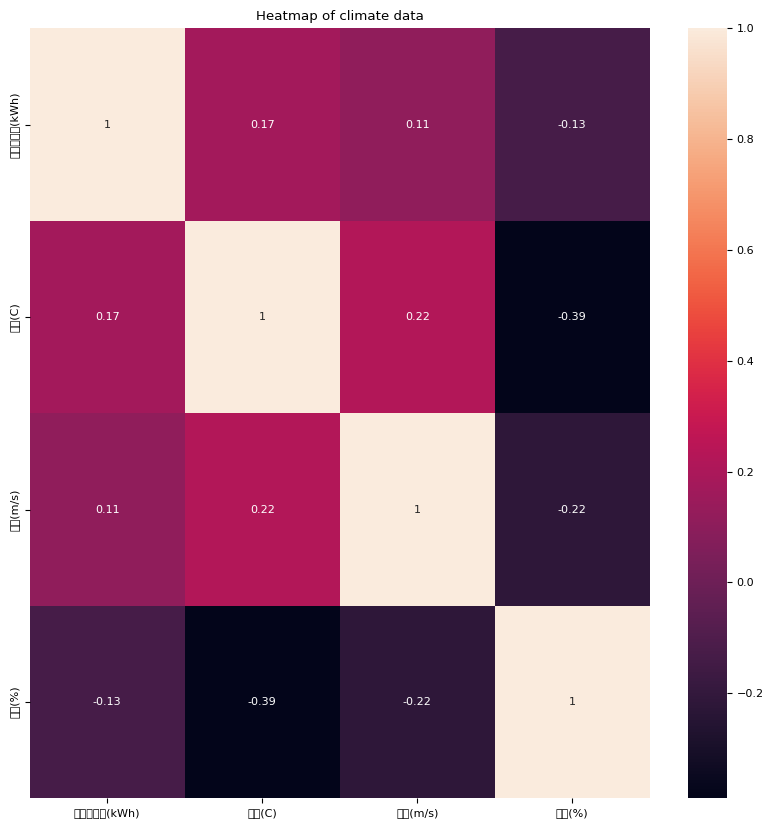

In [22]:
corrMat = train_df[['전력소비량(kWh)', '기온(C)', '풍속(m/s)', '습도(%)']].corr()
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.heatmap(corrMat, annot=True)
ax.set(title = 'Heatmap of climate data')

## Regression Model Fit

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV


gbm_reg = GradientBoostingRegressor(max_depth=4, max_features=0.3144091460070617, random_state=42)
gbm_reg.fit(train_x, np.log(train_y+1))

GradientBoostingRegressor(max_depth=4, max_features=0.3144091460070617,
                          random_state=42)

In [24]:
max_depth = np.random.randint(2, 20, 10)
max_features = np.random.uniform(0.3, 1., 10)

param_distributions = {'max_depth': max_depth, 'max_features': max_features}


In [27]:
reg = RandomizedSearchCV(estimator=gbm_reg, param_distributions=param_distributions, n_iter=100, cv=5, random_state=42, verbose=1, scoring='neg_mean_absolute_percentage_error')
reg.fit(train_x, np.log(train_y+1))
print(f'estimator: {reg.best_estimator_}\nparams:{reg.best_params_}')

estimator: GradientBoostingRegressor(max_depth=4, max_features=0.3144091460070617,
                          random_state=42)
params:{'max_features': 0.3144091460070617, 'max_depth': 4}


## Test Data Pre-Processing

In [12]:
test_df['month'] = test_df['일시'].apply(lambda x : int(x[4:6]))
test_df['day'] = test_df['일시'].apply(lambda x : int(x[6:8]))
test_df['time'] = test_df['일시'].apply(lambda x : int(x[9:11]))

In [13]:
test_x = test_df.drop(columns=['num_date_time', '일시'])

## Inference

In [14]:
preds = gbm_reg.predict(test_x)

## Submission

In [15]:
submission = pd.read_csv('./sample_submission.csv')
submission

,num_date_time,answer
0,1_20220825 00,0
1,1_20220825 01,0
2,1_20220825 02,0
3,1_20220825 03,0
4,1_20220825 04,0
...,...,...
16795,100_20220831 19,0
16796,100_20220831 20,0
16797,100_20220831 21,0
16798,100_20220831 22,0


In [16]:
submission['answer'] = np.exp(preds) - 1
submission

,num_date_time,answer
0,1_20220825 00,1426.289818
1,1_20220825 01,1267.345921
2,1_20220825 02,1318.243844
3,1_20220825 03,1297.471314
4,1_20220825 04,1265.584145
...,...,...
16795,100_20220831 19,1137.891729
16796,100_20220831 20,996.948544
16797,100_20220831 21,793.705554
16798,100_20220831 22,698.529089


In [17]:
submission.to_csv('./gbm_best_submission0718.csv', index=False)